# Example SciDB queries for trade and quote data

This iPython Notebook replicates the work done by AFL queries at [this repo's main page](https://github.com/Paradigm4/TAQ/) in SciDB-py. 

First follow the first few steps on that page to load trades and quotes data into SciDB. The last command you should run there is:
```
./quotes_redim.sh
```

Then let's run some fun queries on the loaded trades and quote (TAQ) data from the comfort of SciDB-Py.

First let us set up the connectivity to the database (and also import some useful libraries)

In [1]:
import matplotlib.pyplot as plt
from scidbpy import connect
import time
#sdb = connect() 
sdb = connect("http://localhost:8080")
afl = sdb.afl

Next, associate Python objects with SciDB arrays (no data transfers yet -- just connections)

In [2]:
trades = sdb.wrap_array('trades')
quotes = sdb.wrap_array('quotes')
tkr = sdb.wrap_array('tkr')

An example lookup

In [3]:
tkr.todataframe().head()

,symbol
symbol_index,
0,A
1,AA
2,AA PR
3,AADR
4,AAIT


## Looking up trades by symbol string

Join with the auxiliary `tkr` array to look up data by ticker symbol name. Here are examples that count the number of trades and quotes for 'BAM'.


In [4]:
symbol = "BAM"
print(sdb.merge(trades,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty())
print(sdb.merge(quotes,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty())

6337
49667


As expected we see more quotes than trades for this instrument. Note that you can also just filter directly by symbol index using `between` if you know it. For example:

In [5]:
tkr.filter("symbol='%s'" % symbol).todataframe()

,symbol
symbol_index,
615,BAM


In [6]:
print(trades.dim_names)
trades.between('null', 615, 'null', 'null', 615, 'null').nonempty()

[u'dummy', u'symbol_index', u'ms']


6337

## Computing minute bars

The trade data are now organized by symbol, time, and a dummy coordinate that separates collisions (due to, say exchanges) in a sparse array.

The following query computes and store one-minute open/high/low/close bars from these data. We need some extra aggregates from the axial_aggregate plugin: load that:

In [7]:
minute_bars = trades.apply('timeprice', 'tuple(ms,price)')
minute_bars = sdb.afl.regrid(minute_bars, 1000, 1, 60000,
            'axial_first(timeprice) as open',
            'max(price) as high',
            'min(price) as low',
            'axial_last(timeprice) as close'
          )
minute_bars = minute_bars.slice('dummy', 0)\
                            .eval()


In [8]:
minute_bars.todataframe().head()

open    high     low  close
symbol_index ms                              
0            570  61.0  63.500  60.025   62.8
             571  62.7  63.500  62.200   63.5
             572  63.6  64.899  63.000   63.6
             573  63.5  64.500  63.500   64.3
             574  64.1  64.400  64.000   64.4

Let's pull out one of these minute bar time series for a particuar stock, CVS. We can consult the symbols array to find it's index directly.

In [9]:
symbol = 'CVS'
tkr[tkr == symbol].todataframe()

,symbol
symbol_index,
1612,CVS


So this says that symbol index 1612 corresponds to CVS.

We can use SciDB's cross_join to avoid an explicit index lookup. We do need to use a repart to bring the symbols array schema into a conformable chunking scheme with the minute_bars array. Only the first 10 minutes of bars are shown below:

In [10]:
mb1 = sdb.merge(minute_bars, 
                tkr[tkr == symbol]).todataframe()
mb1.head()

open  high   low  close symbol
symbol_index ms                                 
1612         513  72.0  72.0  67.1   67.1    CVS
             560  70.1  70.1  70.1   70.1    CVS
             561  70.1  70.2  70.1   70.2    CVS
             563  70.2  70.2  70.2   70.2    CVS
             565  70.2  70.2  70.2   70.2    CVS

Note! That 570 minutes = 9:30 AM.

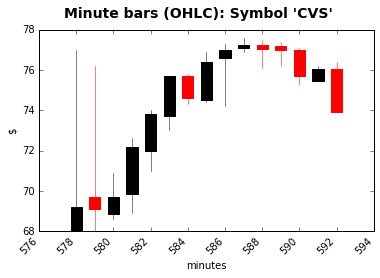

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc

# Split the dimensions to get the minute co-ordinates
l1, l2 = zip(*mb1.index.get_values())
# unify into a nparray of tuples for use in candlestick graph
q2 = zip(l2, mb1.open, mb1.high, mb1.low, mb1.close)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Minute bars (OHLC): Symbol \'CVS\' ', fontsize=14, fontweight='bold')
ax.set_xlabel('minutes')
ax.set_ylabel('$')

candlestick_ohlc(ax, q2[15:30], width=0.6)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

## AsOf join

The `asof` operator joins trade data with quote data. At time points where quote data is not available, the last known value is looked up and filled in. This is sometimes also called a 'last value carry forward' join or 'piecewise constant interpolation join'.

The syntax is:
```
asof(A, B [, aggrDim [, missingCode]])
```

where the inputs are:
- `A & B`: two arrays that have the same dimensionality;
- `aggrDim`: the dimension in A along which to find last_value. Default is the last dimension.
- `missingCode`: the missing code to use, when an A record cannot be found. Default is 0.

Here is an example that joins trades and quotes for **'BAM'**. We use the fact that we know the symbol index for **BAM** is **615** from the last example. In this example, we only choose the values with dummy dimension of **0** (see comments below).

In [12]:
symbol = 'BAM'
tkr[tkr == symbol].todataframe()

,symbol
symbol_index,
615,BAM


Next run some counts for the data for this symbol

In [13]:
print('Dimensions of trades and quotes arrays:')
print(trades.dim_names)
print('\n# of quotes for symbol = %s' % symbol)
q1 = quotes.between('null', 615, 'null', 0, 615, 'null')
print(q1.nonempty())
print('\n# of trades for symbol = %s' % symbol)
t1 = trades.between('null', 615, 'null', 0, 615, 'null')
print(t1.nonempty())


Dimensions of trades and quotes arrays:
[u'dummy', u'symbol_index', u'ms']

# of quotes for symbol = BAM
33447

# of trades for symbol = BAM
4362


Now note that the dimensions of the `quotes` and `trades` arrays did not have identical chunking in the first place. 

In [14]:
from re import search
print(search('\[.*\]', q1.schema).group(0))
print(search('\[.*\]', t1.schema).group(0))

[dummy=0:999,1000,0,symbol_index=0:*,10,0,ms=0:86399999,86400000,0]
[dummy=0:999,1000,0,symbol_index=0:*,10,0,ms=0:86399999,86400000,0]


We resolve this by `redimension`-ing the (smaller) trades subarray for selected symbol to the same dimension schema as the `quotes` subarray

In [15]:
t2 = t1.redimension("<price:double NULL DEFAULT null,volume:int64 NULL DEFAULT null,\
                    sequence_number:int64 NULL DEFAULT null,condition:string NULL DEFAULT null,\
                    exchange:string NULL DEFAULT null> \
                    [dummy=0:999,1000,0,symbol_index=0:*,10,0,ms=0:86399999,86400000,0]")

Next we run the `asof` join and make some simple checks:

In [16]:
asof1 = q1.asof(t2)
print('The head() of the trades array')
t1.todataframe().head()

The head() of the trades array


price  volume  sequence_number condition exchange
dummy symbol_index ms                                                         
0     615          34185171   38.9      91             3309        TI        P
                   34185172   39.0     100             3310       FT         T
                   34185173   38.8      91             3312        TI        T
                   34185950   38.8       9             3313        TI        T
                   34200381   39.8    9761             3695      O           N

In [17]:
print('\n# of elements in the joined result:')
print(asof1.nonempty())
print('\nThe head() of the joined array')
asof1.todataframe().head()


# of elements in the joined result:
4362

The head() of the joined array


ask_price  ask_size  bid_price  bid_size  \
dummy symbol_index ms                                                   
0     615          34185171       41.6         6       37.8         3   
                   34185172       41.6         6       37.8         3   
                   34185173       41.6         6       37.8         3   
                   34185950       42.0         1       37.8         3   
                   34200381       40.1         1       37.0         1   

                             sequence_number condition exchange  price  \
dummy symbol_index ms                                                    
0     615          34185171           300537         R        P   38.9   
                   34185172           300537         R        P   39.0   
                   34185173           300537         R        P   38.8   
                   34185950           300938         R        P   38.8   
                   34200381           305290         R        T   39.8   

                             volume  sequence_number_2 condition_2 exchange_2  
dummy symbol_index ms                                                          
0     615          34185171      91               3309          TI          P  
                   34185172     100               3310         FT           T  
                   34185173      91               3312          TI          T  
                   34185950       9               3313          TI          T  
                   34200381    9761               3695        O             N